In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize
from scipy import stats as sps

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def sample_bm(tn, nsim, mu=0, sigma=1):
    nt = len(tn) - 1
    eps = np.random.randn(nt, nsim) * np.sqrt(np.diff(tn)).reshape(-1, 1)
    X = np.cumsum(eps, axis=0)
    X = np.concatenate((np.zeros((1, nsim)), X))
    X = X * sigma + mu * tn.reshape(-1, 1)
    return X

def sample_gbm(tn, nsim, x0, mu, sigma):
    b = sample_bm(tn, nsim, mu - 0.5 * sigma, sigma)
    return x0 * np.exp(b)

def sample_ou(tn, nsim, x0, theta, alpha, sigma):
    nt = len(tn) - 1
    res = np.zeros((nt + 1, nsim))
    for t in range(nt):
        dt = tn[t + 1] - tn[t]
        e = np.exp(-alpha * dt)
        m = res[t] * e + theta * (1 - e)
        sig = sigma * np.sqrt((1 - e ** 2) / (2 * alpha))
        res[t + 1] = m + sig * np.random.randn(nsim)
    return res

def sample_bridge(tn, nsim, x0, T):
    nt = len(tn) - 1
    res = np.zeros((nt + 1, nsim))
    w = 0
    for t in range(nt):
        dt = tn[t + 1] - tn[t]
        eps = np.sqrt(dt) * np.random.randn(nsim)
        res[t + 1] = res[t] - w * dt + (T - tn[t]) * eps 
        w += eps
    return res


def sample_true_bridge(tn, nsim):
    nt = len(tn) - 1
    res = np.zeros((nt + 1, nsim))
    for t in range(nt):
        dt = tn[t + 1] - tn[t]
        eps = np.sqrt(dt) * np.random.randn(nsim)
        res[t + 1] = res[t] - res[t] / (1 - tn[t]) * dt + eps
    return res

C:\Users\Alex\AppData\Local\Temp\ipykernel_12200\833552117.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=20)


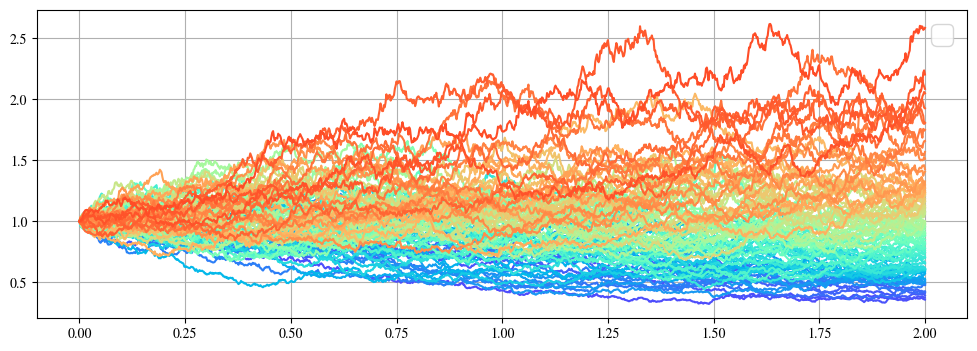

In [55]:
tn = np.linspace(0, 2, 1001)
nsim = 100
x0 = 1
mu = 0.1
sig = 0.3
X = sample_gbm(tn, nsim, x0, mu, sig)
ind = np.argsort(X[-1])
X = X[:, ind]

# Нормализуем eta в диапазон [0, 1] для цветовой карты
colors = rainbow(np.linspace(0.1, 0.9, nsim))

# Создаем график
fig = plt.figure(figsize=(12, 4))
for i in range(len(X[-1])):
    plt.plot(tn, X[:, i], color=colors[i], alpha=1)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()
fig.tight_layout()
# fig.savefig("../2_figs/BM with drift.png")

In [47]:
XX = X.copy()
barrier = 1.5
for j in range(XX.shape[1]):
    mx = XX[0, j]
    for t in range(1, XX.shape[0]):
        mx = max(mx, XX[t, j])
        if mx >= barrier:
            XX[t:, j] = XX[t, j]
            break

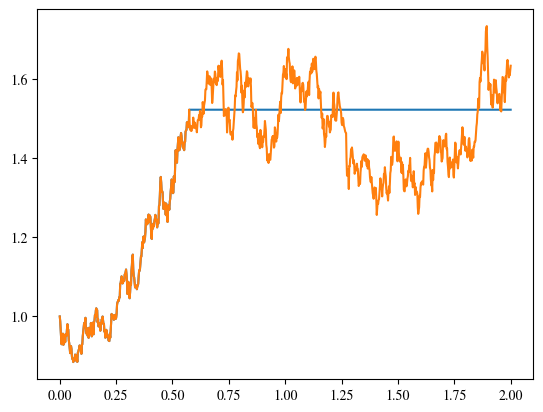

In [46]:
plt.plot(tn, XX[:, -5])
plt.plot(tn, X[:, -5])

C:\Users\Alex\AppData\Local\Temp\ipykernel_12200\2847225690.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=20)


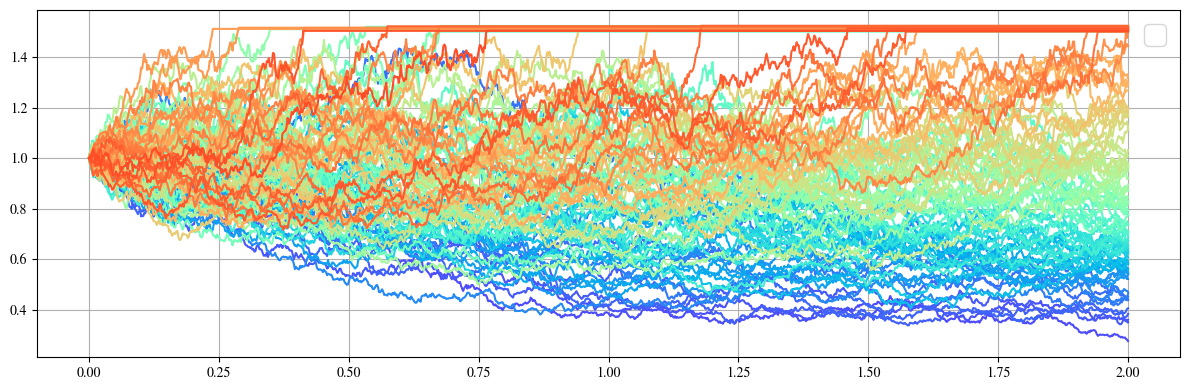

In [56]:
fig = plt.figure(figsize=(12, 4))
for j in range(len(XX[-1])):
    plt.plot(tn, XX[:, j], color=colors[j], alpha=1)
plt.legend(fontsize=20)
plt.grid(True)
fig.tight_layout()
plt.show()

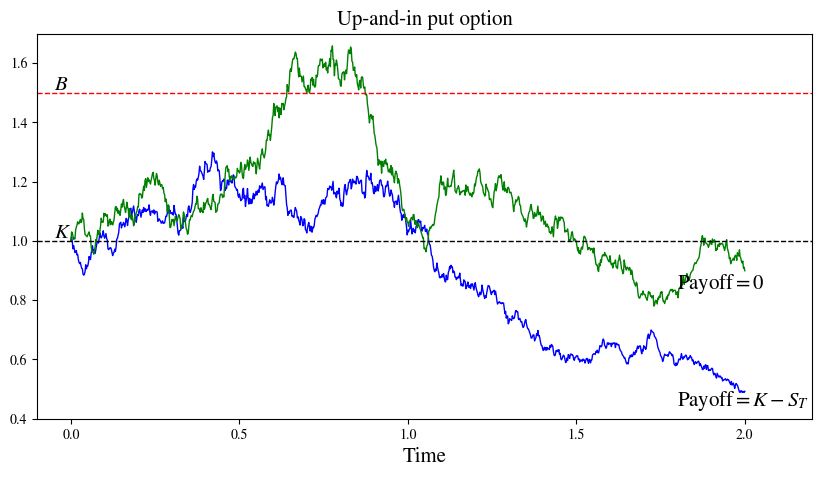

In [109]:
fig = plt.figure(figsize=(10, 5))
plt.title("Up-and-in put option", fontsize=15)
plt.plot(tn, X[:, 10], color='blue', lw=1)
plt.plot(tn, X[:, -50], color='green', lw=1)
plt.axhline(barrier, color='red', linestyle='--', lw=1)
plt.axhline(1.0, color='black', linestyle='--', lw=1)
#plt.axvline(tn[-1], color='black', linestyle='--', lw=1)
plt.text(-0.05, barrier + 0.01, r'$B$', fontsize=15)
plt.text(-0.05, 1.0 + 0.01, r'$K$', fontsize=15)
plt.xlabel("Time", fontsize=15)
plt.text(1.8, X[-1, 10] - 0.05, r'Payoff$=K-S_T$', fontsize=15)
plt.text(1.8, X[-1, -50] - 0.06, r'Payoff$=0$', fontsize=15)
plt.ylim(0.4, 1.7)
plt.xlim(-0.1, 2.2)
fig.savefig('../8_figs/barrer_example.jpg')
plt.show()

In [2]:
import implied_vol

In [76]:
def get_barrier_price(s, r, sigma, T, K, B):
    F = np.exp(r * T) * s
    theta = sigma * np.sqrt(T)
    gamma = r - 0.5 * sigma ** 2
    p1 = implied_vol.BSput(F, K, theta)
    p2 = implied_vol.BSput(B ** 2 / s * np.exp(r * T), K, theta)
    gamma = r - 0.5 * sigma ** 2
    w = (B / s) ** (2 * gamma / sigma ** 2)
    res = p1 - w * p2
    return res * np.exp(-r * T)

def get_barrier_delta(s, r, sigma, T, K, B):
    eps = 1e-3

    mid = get_barrier_price(s, r, sigma, T, K, B) 
    up = get_barrier_price(s + eps, r, sigma, T, K, B)
    dwn = get_barrier_price(s - eps, r, sigma, T, K, B)
    
    delta = (up - dwn) / (2 * eps)
    gamma = (up - 2 * mid + dwn) / eps ** 2
    
    return delta, gamma

In [131]:
from scipy import stats as sps

def get_put_price(s, r, sigma, T, K):
    F = np.exp(r * T) * s
    theta = sigma * np.sqrt(T)
    p1 = implied_vol.BSput(F, K, theta)
    return p1 * np.exp(-r * T)


def get_put_b_price(s, r, sigma, T, K, B):
    b = np.minimum(K, B)
    theta = np.sqrt(T) * sigma
    F = np.exp(r * T) * s
    d1 = np.log(F / b) / theta + theta / 2
    d2 = np.log(F / b) / theta - theta / 2
    
    n1 = sps.norm.cdf(-d1)
    n2 = sps.norm.cdf(-d2)
    return K * np.exp(-r * T) * n2 - s * n1


def get_barrier_price(s, r, sigma, T, K, B):
    p1 = get_put_b_price(s, r, sigma, T, K, B)
    p2 = get_put_b_price(B ** 2 / s, r, sigma, T, K, B)
    gamma = r - 0.5 * sigma ** 2
    w = (B / s) ** (2 * gamma / sigma ** 2)
    return (p1 - w * p2) * (s < B)

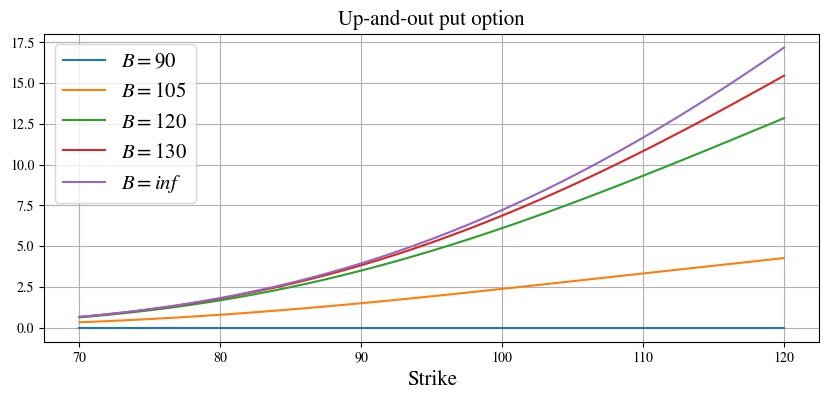

In [134]:
s = 100
k = 100
T = 1
sigma = 0.3
r = 0.1

strikes = np.linspace(70, 120, 100)

prices = get_barrier_price(s, r, sigma, T, strikes, barrier)

bars = [90, 105, 120, 130, 1e20]
prices = [get_barrier_price(s, r, sigma, T, strikes, b) for b in bars]
prices = np.array(prices)
bars[-1] = np.inf
prices[-1] = get_put_price(s, r, sigma, T, strikes)

fig = plt.figure(figsize=(10, 4))
plt.plot(strikes, prices.T)
plt.title("Up-and-out put option", fontsize=15)
plt.legend([fr'$B={b}$' for b in bars], fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.show()
fig.savefig('../8_figs/barrier_put_prices.jpg')

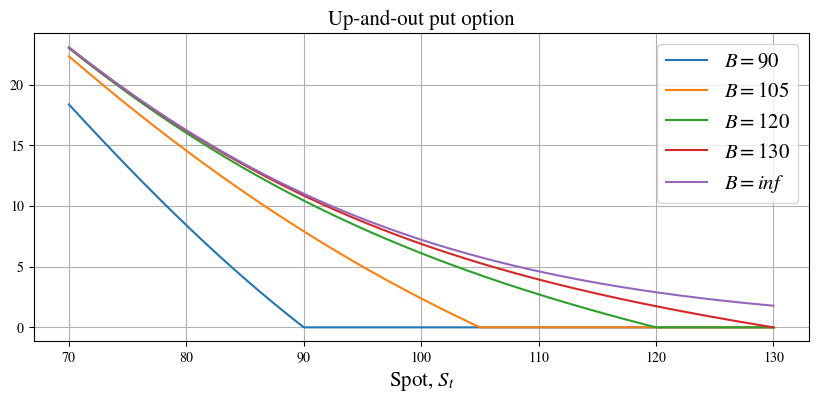

In [138]:
s = 100
k = 100
T = 1
sigma = 0.3
r = 0.1

strike = 100
spots = np.linspace(70, 130, 10000)
bars = [90, 105, 120, 130, 1e20]
prices = [get_barrier_price(spots, r, sigma, T, strike, b) for b in bars]
prices = np.array(prices)
bars[-1] = np.inf

fig = plt.figure(figsize=(10, 4))
plt.plot(spots, prices.T)
plt.title("Up-and-out put option", fontsize=15)
plt.legend([fr'$B={b}$' for b in bars], fontsize=15)
plt.grid()
plt.xlabel(r"Spot, $S_t$", fontsize=15)
plt.show()
fig.savefig('../8_figs/barrier_put_prices_vs_spot.jpg')

In [80]:
delta, gamma = get_barrier_delta(s, r, sigma, T, strikes, 120)
delta_put, gamma_put = get_barrier_delta(s, r, sigma, T, strikes, 1e20)

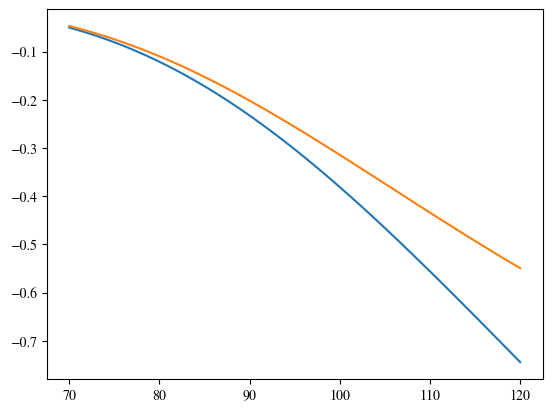

In [81]:
plt.plot(strikes, delta)
plt.plot(strikes, delta_put)

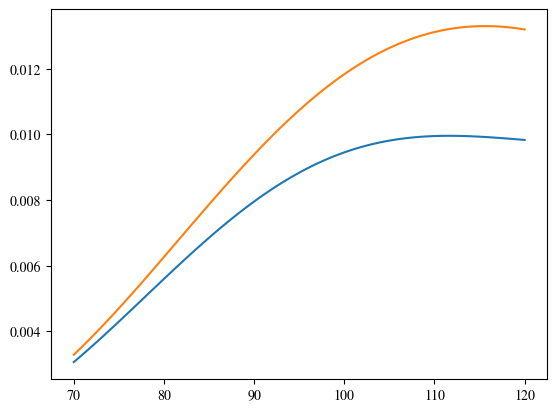

In [82]:
plt.plot(strikes, gamma)
plt.plot(strikes, gamma_put)

In [84]:
def get_payoff(S, K, B):
    phi = (K - S).clip(0.0)
    return phi * (S <= B)

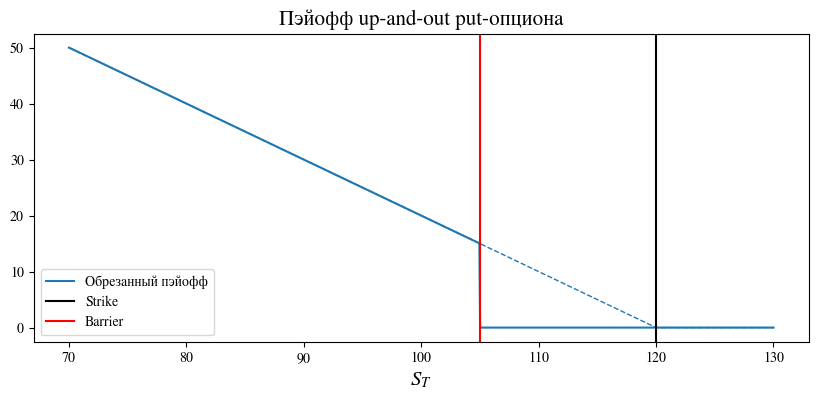

In [139]:
S = np.linspace(70, 130, 1000)
K = 120
B = 105

fig = plt.figure(figsize=(10, 4))
plt.title(r"Пэйофф up-and-out put-опциона", fontsize=15)
plt.plot(S, get_payoff(S, K, B), label='Обрезанный пэйофф')
plt.plot(S, get_payoff(S, K, 10000), color='tab:blue', linestyle='--', lw=1)
plt.xlabel(r"$S_T$", fontsize=15)
plt.axvline(K, color='black', label='Strike')
plt.axvline(B, color='red', label='Barrier')
plt.legend()
plt.show()
fig.savefig('../8_figs/barrier_put_payoff.jpg')